In [2]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
df = pd.read_csv("data/train.csv", index_col=0)
# df['Deck'] = df[~df['Cabin'].isnull()]['Cabin'].str[0]
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df['FamSize'] = df['Parch'] + df['SibSp']

decks_df = df['Cabin'].str.extract('(?P<Deck>\w)(?P<CabinNumber>\d+)', expand=True)
deck_dummies = pd.get_dummies(decks_df['Deck'], prefix='Deck')
title_dummies = pd.get_dummies(df['Title'])
gender_dummies = pd.get_dummies(df['Sex'])
class_dummies = pd.get_dummies(df['Pclass'], prefix='Class')

# saving to variables and using .concat() once seems to be much faster
df = pd.concat([df, decks_df, deck_dummies, title_dummies, gender_dummies, class_dummies], axis=1)

In [6]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Logistic Regression (no feature engineering)

In [111]:
X = df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].dropna()
y = X.pop('Survived')

In [112]:
df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [113]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000
mean,2.236695,29.699118,0.512605,0.431373,34.694514
std,0.838250,14.526497,0.929783,0.853289,52.918930
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,1.000000,20.125000,0.000000,0.000000,8.050000
50%,2.000000,28.000000,0.000000,0.000000,15.741700
75%,3.000000,38.000000,1.000000,1.000000,33.375000
max,3.000000,80.000000,5.000000,6.000000,512.329200


In [114]:
X_train_minimal, X_test_minimal, y_train_minimal, y_test_minimal = train_test_split(X, y)

logreg = LogisticRegressionCV(n_jobs=-1)

logreg.fit(X_train_minimal, y_train_minimal)

y_pred = logreg.predict(X_test_minimal)

cfn_matrix_minimal = confusion_matrix(y_test_minimal, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[93 13]
 [37 36]]


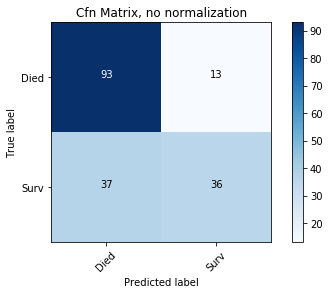

In [115]:
cfn_matrix_minimal = confusion_matrix(y_test_minimal, y_pred)
plt.figure()
plot_confusion_matrix(cfn_matrix_minimal, ['Died', 'Surv'], title="Cfn Matrix, no normalization")

Normalized confusion matrix
[[ 0.88  0.12]
 [ 0.51  0.49]]


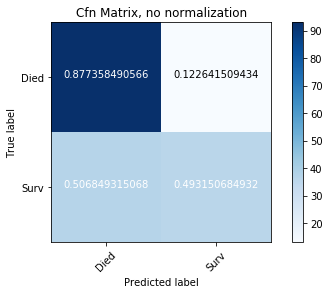

In [116]:
cfn_matrix_minimal = confusion_matrix(y_test_minimal, y_pred)
plt.figure()
plot_confusion_matrix(cfn_matrix_minimal, ['Died', 'Surv'], normalize=True, title="Cfn Matrix, no normalization")

In [117]:
print(classification_report(y_test_minimal, y_pred, target_names=['Died', 'Surv']))

             precision    recall  f1-score   support

       Died       0.72      0.88      0.79       106
       Surv       0.73      0.49      0.59        73

avg / total       0.72      0.72      0.71       179



In [118]:
logreg.score(X,y)

0.71008403361344541

In [119]:
precision_score(y_test_minimal, y_pred)

0.73469387755102045

In [121]:
recall_score(y_test_minimal, y_pred)

0.49315068493150682

### Logistic Regression (with added features)

In [122]:
X = df[df.corr().columns].dropna()
y = X.pop('Survived')

In [123]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare,FamSize,Deck_A,Deck_B,Deck_C,Deck_D,...,Mrs,Ms,Rev,Sir,the Countess,female,male,Class_1,Class_2,Class_3
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,...,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,2.236695,29.699118,0.512605,0.431373,34.694514,0.943978,0.016807,0.063025,0.071429,0.039216,...,0.151261,0.001401,0.008403,0.001401,0.001401,0.365546,0.634454,0.260504,0.242297,0.497199
std,0.838250,14.526497,0.929783,0.853289,52.918930,1.483788,0.128637,0.243179,0.257720,0.194244,...,0.358554,0.037424,0.091348,0.037424,0.037424,0.481921,0.481921,0.439217,0.428773,0.500343
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,20.125000,0.000000,0.000000,8.050000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,28.000000,0.000000,0.000000,15.741700,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,3.000000,38.000000,1.000000,1.000000,33.375000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,3.000000,80.000000,5.000000,6.000000,512.329200,7.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [137]:
X_train_features, X_test_features, y_train_features, y_test_features = train_test_split(X, y)

logreg = LogisticRegressionCV(n_jobs=-1)

logreg.fit(X_train_features, y_train_features)

y_pred = logreg.predict(X_test_features)

cfn_matrix_features = confusion_matrix(y_test_features, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[79 14]
 [24 62]]


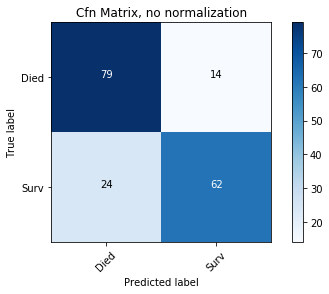

In [139]:
plt.figure()
plot_confusion_matrix(cfn_matrix_features, ['Died', 'Surv'], title="Cfn Matrix, no normalization")

Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.28  0.72]]


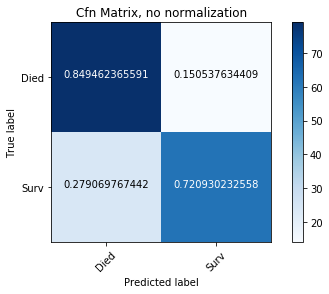

In [140]:
plt.figure()
plot_confusion_matrix(cfn_matrix_features, ['Died', 'Surv'], normalize=True, title="Cfn Matrix, no normalization")

In [141]:
print(classification_report(y_test_features, y_pred, target_names=['Died', 'Surv']))

             precision    recall  f1-score   support

       Died       0.77      0.85      0.81        93
       Surv       0.82      0.72      0.77        86

avg / total       0.79      0.79      0.79       179



In [142]:
logreg.score(X, y)

0.834733893557423

In [143]:
precision_score(y_test_features, y_pred)

0.81578947368421051

In [144]:
recall_score(y_test_features, y_pred)

0.72093023255813948

In [146]:
logreg.C_

array([ 21.54])

In [148]:
logreg.Cs_

array([  1.00e-04,   7.74e-04,   5.99e-03,   4.64e-02,   3.59e-01,
         2.78e+00,   2.15e+01,   1.67e+02,   1.29e+03,   1.00e+04])